In [7]:
# Let's use the data generated from earlier post on flux balance analysis with COBRApy
# The output from flux balance analysis is a highly sparse matrix, with rows corresponding to different growth conditions (given by user), and columns corresponding to the fluxes.
# This project is re-analyses of some of the data already published in [Pubmed ID]. The earlier work was done when I was at CCBB and Wilke lab.
# import flux balance related modules
from __future__ import print_function
import cobra
# import deep learning and other modules
import numpy as np
import pandas as pd
from os.path import join


c:\users\viswa\appdata\local\programs\python\python37\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [8]:
# fix random seed for reproducibility
seed = 7
np.random.seed(7)

In [9]:
# Flux dataset from predicting bacterial growth conditions study -- for current purposes, THIS IS MOSTLY CONSIDERED RANDOM SYNTHETIC DATA
dataset1 = pd.read_csv("../Data/syntheticFluxData.csv", delimiter=',', header=None)

In [10]:
dataset1.head()

,0,1,2,3,4,5,6,7,8,9,...,2375,2376,2377,2378,2379,2380,2381,2382,2383,2384
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0,0,0.004649,0,0.004649,1,1,1
1,0.000000e+00,4.692800e-34,1.025800e-27,6.151300e-29,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0,0,0.004571,0,0.004571,1,2,2
2,1.348900e-29,0.000000e+00,0.000000e+00,7.639300e-28,1.029200e-27,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0,0,0.006978,0,0.006978,1,3,3
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0,0,0.004584,0,0.004584,1,4,4
4,0.000000e+00,0.000000e+00,0.000000e+00,2.695900e-29,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,0.0,-0.0,0,0,0.004760,0,0.004760,1,5,5


In [11]:
# First 2381 columns are the in-silico fluxes generated from the flux balance analyses (FBA) for the input growth conditions
# Information on the growth conditions is in columns 2382 and 2383. Column 2384 is just the pair-wise combination of 2382 and 2383.
# Original work has lot of details, and this is just a tutorial on how the processed FBA data looks and using deep learning models to analyze.
# Focus is on deep learning models, rather than the source or content of the data.
print("Background information of the data and what we are trying to accomplish here - after importing modules and loading data :-)")


Background information of the data and what we are trying to accomplish here - after importing modules and loading data :-)


In [12]:
# Assuming iAF1260 model used in this repo has exchange/transport reactions that match to the synthetic data.
sbml_path = join("../Data","iAF1260.xml.gz")
iAF1260_ecoli_model = cobra.io.read_sbml_model(sbml_path)
iAF1260_reaction_IDs = [x.id for x in iAF1260_ecoli_model.reactions]
# There might be a better way to do this, but this explicitly conveys information
list_tpp_tex = []
for x in iAF1260_reaction_IDs:
    if(x.endswith('tpp')):
        list_tpp_tex.append(x)
    if(x.endswith('tex')):
        list_tpp_tex.append(x)
# columns to remove from above dataset
IDs_of_cols_to_remove = [iAF1260_reaction_IDs.index(i) for i in list_tpp_tex]
# append output columns as well that are to be removed from Input
IDs_of_cols_to_remove.extend(range(2382,2385)) # Note range covers 2382 to 2384


In [13]:
# retain columns that are NOT IDs_of_cols_to_remove, fit in regression methods automatically scales these
X = dataset1.iloc[:,dataset1.columns.difference(IDs_of_cols_to_remove)]
# Use carbon source as y (i.e., col 2382) --- Nitrogen source is 2383, while pair-wise C/N is 2384
fba_y = dataset1.iloc[:,2382]

In [14]:
# Two ways to approach this multi-class problem using scikit-learn Logistic regrssion models are 1. ovr, 2. multinomial
# The goal is to predict the growth condition given the metabolic fluxes, so I think may be "ovr" i.e., one vs rest model is better.
# Let's try that for now :-) - If we have to go back and re-do with multinomial and compare the results, we can always do that.
print("Background information of the data")

Background information of the data


In [16]:
X.head()

,0,1,2,3,4,5,6,11,12,17,...,2368,2369,2370,2371,2372,2374,2375,2377,2378,2380
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.2,0.0,...,-0.0,0.6,-0.0,-0.0,0.0,0,0.0,0,0,0
1,0.000000e+00,4.692800e-34,1.025800e-27,6.151300e-29,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.8,-0.0,0.2,0.2,0,0.0,0,0,0
2,1.348900e-29,0.000000e+00,0.000000e+00,7.639300e-28,1.029200e-27,0.0,0.0,0.0,0.2,0.0,...,-0.0,0.6,-0.0,-0.0,0.0,0,0.0,0,0,0
3,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.6,-0.0,-0.0,0.0,0,0.0,0,0,0
4,0.000000e+00,0.000000e+00,0.000000e+00,2.695900e-29,0.000000e+00,0.0,0.0,0.0,0.0,0.0,...,-0.0,0.6,-0.0,-0.0,0.0,0,0.0,0,0,0


In [19]:
# Split data into training and test (note the encoded_y is a single column)
from sklearn.model_selection import train_test_split
X_train, X_test, fba_y_train, fba_y_test = train_test_split(X, fba_y, test_size=0.25, random_state=0)

In [22]:
from sklearn.linear_model import Lasso
lasso_fba = Lasso(alpha=1)

In [23]:
lasso_fba.fit(X_train, fba_y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
# Let's see out of couple of thousand features, which are at least greater than 0.01 
lasso_fba.coef_[lasso_fba.coef_ > 0.01]

array([0.13498902, 0.05082819, 0.01110022, 0.08149858])

In [29]:
# Use test data to predict
y_predict = lasso_fba.predict(X_test)

Text(0, 0.5, 'y-test')

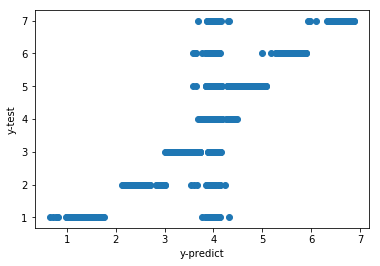

In [35]:
## Looks like we did liinear regresssion, not  logistic regression ( a simple test !)
import matplotlib.pyplot as plt
plt.scatter(y_predict, fba_y_test)
plt.xlabel('y-predict')
plt.ylabel('y-test')


In [42]:
# THIS IS THE KEY FOR THE ENTIRE SCRIPT - LOOK AT THE PENALTY WHICH IS POSSIBLE WITH SOLVER AND ONE-VERSUS-REST METHOD
# ALSO NOTE THE NUMBER OF ITERATIONS THAT ARE VERY VERY HIGH -- I USED THE SAME ITERATIONS FROM THE ORIGINAL PAPER
# LOWER ITERATIONS MIGHT NOT GET CONVERGED!
from sklearn.linear_model import LogisticRegression
log_lasso_fba = LogisticRegression(penalty='l2', solver='sag', multi_class='ovr', max_iter=9000000)

In [43]:
log_lasso_fba.fit(X_train, fba_y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=9000000, multi_class='ovr',
          n_jobs=None, penalty='l2', random_state=None, solver='sag',
          tol=0.0001, verbose=0, warm_start=False)

In [45]:
fba_y_test_log = log_lasso_fba.predict(X_test)

In [48]:
#As I mentioned in the previous post related to flux balance analysis with COBRApy, I used R version of COBRA for flux balance analyses
#and R version of GLMNET package (to perform lasso analyses). Here, my focus is to use python modules and focus on lasso and other logistic regression methods.

#The data to be analyzed is the output of the flux balance analyses. FBA output is a vector of metabolic fluxes. If you consider multiple grown conditions, you will end up with a matrix i.e., each growth condition results in a set of fluxes.
#Here, we try to predict the original growth conditions using the FBA output. Since the metabolic model has close to couple of thousand reacitons, this is a high-dimensional feature dataset.

#The data considered has some artificial noise introduced (more info: look at the original paper) and the idea is to generate replicates for training the model(ideas from original authors)
#Given replicates for each growth condition, we can use subset to train the model and the rest to test OR we can use cross-validation to measure the accuracy of the model.

#Original R script can be found here: https://github.com/viswam78/Ecoli_FBA_input_prediction/blob/master/Analysis/Scripts/GLMNET.R (from Wilke lab)
#diagonal means they are correctly predicted. Better to look at the confusion matrix?       


In [49]:
# confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(fba_y_test, fba_y_test_log)

array([[143,   0,   0,  25,   0,   1,   0],
       [  0, 151,   0,  22,   0,   2,   0],
       [  0,   0, 157,  18,   0,   0,   0],
       [  0,   0,   0, 177,   1,   0,   0],
       [  0,   0,   0,  32, 138,   1,   0],
       [  0,   0,   0,  29,   0, 146,   0],
       [  0,   0,   2,  29,   0,   0, 151]], dtype=int64)

In [61]:
# We have to go back and see what 4th column is. This growth condition gets predicted as other types as well.
# https://github.com/clauswilke/Ecoli_FBA_input_prediction/blob/master/Manuscript/Figures/Fig3.pdf
# Same as the case from the original study where other sources sometimes get predicted as acetate - for detailed, explanation read the original paper from Wilke lab.


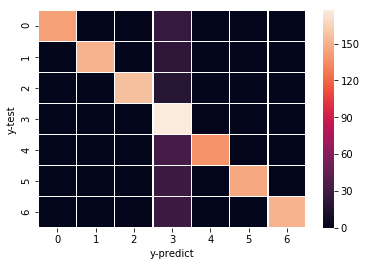

In [60]:
data_4_heatmap = confusion_matrix(fba_y_test, fba_y_test_log)
import matplotlib.pyplot as plt
import seaborn as sns
ax = sns.heatmap(data_4_heatmap, linewidth=0.5)
plt.xlabel('y-predict')
plt.ylabel('y-test')
plt.show()